In [169]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
from typing import Union, Optional
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm, trange
DEVICE = torch.device("cpu")

# Define classes and functions

In [151]:
class RegressionData(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.scaler = MinMaxScaler()
        self.x = df[['Periods','appliances']].values
        self.x[:, 1] /= 1
    
    def __len__(self):
        return (len(self.x) // 96) - 8
    
    def __getitem__(self, idx):
        if idx > 358:
            raise Exception('Unbounded window')
        return torch.tensor(self.x[idx*96:(idx+7)*(96)], dtype=torch.float32), torch.tensor(self.x[(idx+7)*96:(idx+8)*96], dtype=torch.float32)

In [152]:
class MyRNN(nn.Module):
    def __init__(self, hid_size, LSTM=False):
        super(MyRNN, self).__init__()
        self.hidden_size = hid_size
        self.LSTM = LSTM
        if LSTM:
            self.rnn = nn.LSTM(input_size=2, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size=2, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
            
        self.fc2 = nn.Linear(self.hidden_size, 1)
        
    def forward(self, inputs, hidden_state, cell=None):
        if self.LSTM:
            output, (hidden_states, cell) = self.rnn(inputs, (hidden_state, cell))
        else:
            output, hidden_states = self.rnn(inputs, hidden_state)
        output = self.fc2(output)
        return output, hidden_states, cell

In [153]:
epochs = 1
def train(net, train_loader):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
    net.train()
    val_losses = []
    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        for x, Y in train_loader:
            Y = Y.to(DEVICE)
            x = x.to(DEVICE)
            hidden = torch.zeros((num_layers, batch_size, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers, batch_size, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            output, _, _ = net(Y, hidden, cell)
            z = torch.cat([outs[:, -1], output[:, :-1].squeeze()], dim=1)
            loss = criterion(Y[:, :, 1], z)
            val_losses.append(loss.item())    
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            #print(f'{loss.item()}\r')
            optimizer.zero_grad()
        print(f'{total_loss / len(train_loader)}')
    return val_losses

In [154]:
def test(net, dataset):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    net.eval()
    val_losses = []
    outputs = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, Y = dataset[i]
            hidden = torch.zeros((num_layers, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            z = [outs[-1].squeeze().item()]
            for i in range(95):
                o, hidden, cell = net(torch.tensor([[i+1, z[-1]]]), hidden, cell)
                z.append(o.item())
            loss = criterion(Y[:, 1], torch.tensor(z))
            val_losses.append(loss.item())
            outputs += z
    return val_losses, [p *1 for p in outputs]

# Define the federated learning functions and hyperparameters

In [155]:
batch_size = 8
hidden_size = 64

In [156]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [157]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset
        self.losses = []

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.dataset)
        self.losses = loss
        return get_parameters(self.net), len(self.dataset), {'loss': np.mean(loss)}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        return 0.0, 1, {}


In [158]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    cid = int(cid) + 1
    net = MyRNN(hid_size=hidden_size).to(DEVICE)
    d = RegressionData(f'./data/Consumer{cid}.csv')
    train_loader = DataLoader(d, batch_size=batch_size, shuffle=True, drop_last=True)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader)


In [159]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]],
    ):
        """Aggregate model weights using weighted average and store checkpoint"""
        net = MyRNN(hid_size=64).to(DEVICE)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(net.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [160]:
def agg(metrics):
    losses = np.mean([m[-1]["loss"] for m in metrics])
    return {'losses': losses}

In [161]:
# Create FedAvg strategy
strategy = SaveModelStrategy(
    fraction_fit=0.25,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=40,  # Wait until all 10 clients are available
    fit_metrics_aggregation_fn= agg
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
res = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-11-02 14:49:35,854 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-11-02 14:49:39,391	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2023-11-02 14:49:39,914 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 8411191706.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8411191706.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-11-02 14:49:39,915 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-02 14:49:39,916 | app.py:224 | Flower VCE: Resources for each Virtual Client

(DefaultActor pid=26251) 0.3210696771063588


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-11-02 14:49:47,395 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:49:47,406 | server.py:173 | evaluate_round 1: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 1: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:49:47,535 | server.py:187 | evaluate_round 1 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 20 results and 0 failures
WARNING flwr 2023-11-02 14:49:47,536 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-02 14:49:47,536 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 40)


Saving round 1 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.67s/it] [repeated 12x across cluster]


(DefaultActor pid=26248) 0.10086982866579836 [repeated 12x across cluster]


DEBUG flwr 2023-11-02 14:49:51,629 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:49:51,641 | server.py:173 | evaluate_round 2: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 2: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:49:51,774 | server.py:187 | evaluate_round 2 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:49:51,775 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 40)


Saving round 2 aggregated_parameters...


100%|██████████| 1/1 [00:03<00:00,  3.40s/it] [repeated 15x across cluster]


(DefaultActor pid=26246) 0.32039683616974135 [repeated 15x across cluster]


DEBUG flwr 2023-11-02 14:49:55,723 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:49:55,734 | server.py:173 | evaluate_round 3: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 3: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:49:55,861 | server.py:187 | evaluate_round 3 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:49:55,861 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 40)


Saving round 3 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 12x across cluster]
DEBUG flwr 2023-11-02 14:49:59,827 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:49:59,838 | server.py:173 | evaluate_round 4: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 4: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:49:59,965 | server.py:187 | evaluate_round 4 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:49:59,965 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 40)


Saving round 4 aggregated_parameters...


100%|██████████| 1/1 [00:01<00:00,  1.98s/it] [repeated 13x across cluster]


(DefaultActor pid=26247) 0.2983636517416347 [repeated 13x across cluster]


DEBUG flwr 2023-11-02 14:50:03,988 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:03,999 | server.py:173 | evaluate_round 5: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 5: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:04,128 | server.py:187 | evaluate_round 5 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:04,129 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 40)


Saving round 5 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.82s/it] [repeated 16x across cluster]


(DefaultActor pid=26250) 0.07525443361902778 [repeated 16x across cluster]


DEBUG flwr 2023-11-02 14:50:08,148 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:08,158 | server.py:173 | evaluate_round 6: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 6: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:08,284 | server.py:187 | evaluate_round 6 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:08,285 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 40)


Saving round 6 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 12x across cluster]
DEBUG flwr 2023-11-02 14:50:12,294 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures
100%|██████████| 1/1 [00:01<00:00,  1.76s/it] [repeated 12x across cluster]
DEBUG flwr 2023-11-02 14:50:12,305 | server.py:173 | evaluate_round 7: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 7: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:12,432 | server.py:187 | evaluate_round 7 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:12,432 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 40)


Saving round 7 aggregated_parameters...
(DefaultActor pid=26245) 0.2712367248128761 [repeated 12x across cluster]


DEBUG flwr 2023-11-02 14:50:16,506 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:16,517 | server.py:173 | evaluate_round 8: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 8: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:16,648 | server.py:187 | evaluate_round 8 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:16,648 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 40)
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


Saving round 8 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.02s/it] [repeated 12x across cluster]


(DefaultActor pid=26245) 0.3793545202775435 [repeated 12x across cluster]


DEBUG flwr 2023-11-02 14:50:20,666 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:20,676 | server.py:173 | evaluate_round 9: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 9: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:20,801 | server.py:187 | evaluate_round 9 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:20,802 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 40)


Saving round 9 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.92s/it] [repeated 15x across cluster]


(DefaultActor pid=26248) 0.13118636066263373 [repeated 15x across cluster]


DEBUG flwr 2023-11-02 14:50:24,818 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:24,828 | server.py:173 | evaluate_round 10: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 10: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:24,955 | server.py:187 | evaluate_round 10 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:24,955 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 40)


Saving round 10 aggregated_parameters...


100%|██████████| 1/1 [00:01<00:00,  1.82s/it] [repeated 13x across cluster]
DEBUG flwr 2023-11-02 14:50:28,971 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:28,981 | server.py:173 | evaluate_round 11: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 11: strategy sampled 20 clients (out of 40)


(DefaultActor pid=26247) 0.274695866487243 [repeated 13x across cluster]
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-11-02 14:50:29,109 | server.py:187 | evaluate_round 11 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:29,110 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:33,086 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:33,097 | server.py:173 | evaluate_round 12: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 12: strategy sampled 20 clients (out of 40)
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-11-02 14:50:33,225 | server.py:187 | evaluate_round 12 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:33,225 | server.py:222 | fit_round 13: strategy sa

Saving round 12 aggregated_parameters...


100%|██████████| 1/1 [00:01<00:00,  2.00s/it] [repeated 12x across cluster]


(DefaultActor pid=26247) 0.261442820456895 [repeated 12x across cluster]


DEBUG flwr 2023-11-02 14:50:37,425 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:37,435 | server.py:173 | evaluate_round 13: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 13: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:37,565 | server.py:187 | evaluate_round 13 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:37,565 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 40)


Saving round 13 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.76s/it] [repeated 12x across cluster]


(DefaultActor pid=26251) 0.27131409638307313 [repeated 12x across cluster]


DEBUG flwr 2023-11-02 14:50:41,639 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:41,648 | server.py:173 | evaluate_round 14: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 14: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:41,777 | server.py:187 | evaluate_round 14 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:41,777 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 40)


Saving round 14 aggregated_parameters...


100%|██████████| 1/1 [00:01<00:00,  1.76s/it] [repeated 16x across cluster]
DEBUG flwr 2023-11-02 14:50:45,787 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:45,797 | server.py:173 | evaluate_round 15: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 15: strategy sampled 20 clients (out of 40)


(DefaultActor pid=26247) 0.06126702170480381 [repeated 16x across cluster]
Saving round 15 aggregated_parameters...


DEBUG flwr 2023-11-02 14:50:45,926 | server.py:187 | evaluate_round 15 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:45,926 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 40)
  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-11-02 14:50:50,085 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:50,096 | server.py:173 | evaluate_round 16: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 16: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:50,226 | server.py:187 | evaluate_round 16 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:50,227 | server.py:222 | fit_round 17: strategy sa

Saving round 16 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.05s/it] [repeated 12x across cluster]


(DefaultActor pid=26245) 0.008437499853740022 [repeated 12x across cluster]


DEBUG flwr 2023-11-02 14:50:54,265 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:54,275 | server.py:173 | evaluate_round 17: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 17: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:54,404 | server.py:187 | evaluate_round 17 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:54,405 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 40)


Saving round 17 aggregated_parameters...


100%|██████████| 1/1 [00:02<00:00,  2.94s/it] [repeated 14x across cluster]


(DefaultActor pid=26244) 0.05369879284196279 [repeated 14x across cluster]


DEBUG flwr 2023-11-02 14:50:58,429 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:50:58,439 | server.py:173 | evaluate_round 18: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 18: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:50:58,567 | server.py:187 | evaluate_round 18 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:50:58,568 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 40)


Saving round 18 aggregated_parameters...


100%|██████████| 1/1 [00:01<00:00,  1.81s/it] [repeated 14x across cluster]


(DefaultActor pid=26247) 0.07109771575778723 [repeated 14x across cluster]


DEBUG flwr 2023-11-02 14:51:02,753 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:51:02,764 | server.py:173 | evaluate_round 19: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 19: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:51:02,890 | server.py:187 | evaluate_round 19 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 20 results and 0 failures
DEBUG flwr 2023-11-02 14:51:02,891 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 40)


Saving round 19 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-11-02 14:51:06,851 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures
DEBUG flwr 2023-11-02 14:51:06,861 | server.py:173 | evaluate_round 20: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 20: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-11-02 14:51:06,991 | server.py:187 | evaluate_round 20 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 20 results and 0 failures
INFO flwr 2023-11-02 14:51:06,991 | server.py:153 | FL finished in 85.32677591696847
INFO:flwr:FL finished in 85.32677591696847
INFO flwr 2023-11-02 14:51:06,992 | app.py:225 | app_fit: losses_distributed [(1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0)]
INF

Saving round 20 aggregated_parameters...


# Training performance

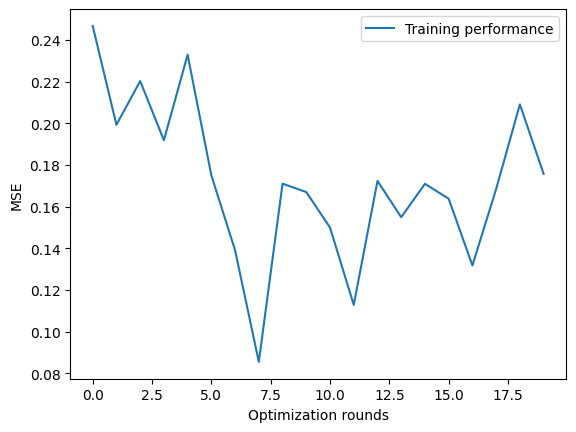

In [162]:
train_losses = [x[1] for x in res.metrics_distributed_fit['losses']]
plt.plot(train_losses, label='Training performance')
plt.legend()
plt.xlabel('Optimization rounds')
plt.ylabel('MSE')
plt.show()

# Evaluate on test

In [163]:
model_round = 20
net = MyRNN(hid_size=hidden_size)
net.load_state_dict(torch.load(f'./model_round_{model_round}.pth'), strict=False)

<All keys matched successfully>

### Evaluate over the whole test dataset

In [146]:
mse = []
for i in trange(41, 51):
    eval_dataset = RegressionData(f'./data/Consumer{i}.csv')
    loss, _ = test(net, eval_dataset)
    mse += loss
print(f'Total test MSE: {np.mean(mse)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.80s/it]

Total test MSE: 0.02122908487432121


### Per consumer

In [164]:
eval_dataset = RegressionData(f'./data/Consumer49.csv')

In [165]:
loss, outs = test(net, eval_dataset)

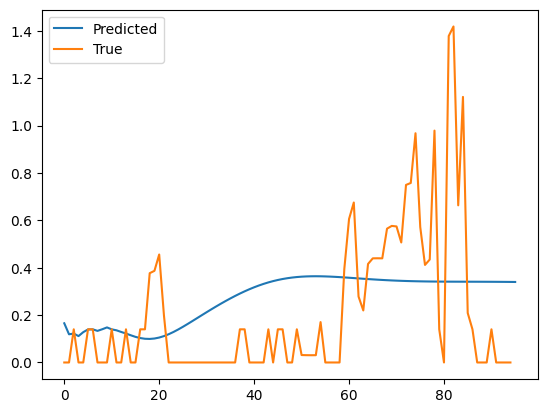

In [166]:
plt.plot(outs[:96], label='Predicted')
plt.plot(eval_dataset[0][1][:95, 1], label='True')
plt.legend()
plt.show()

# Analysis

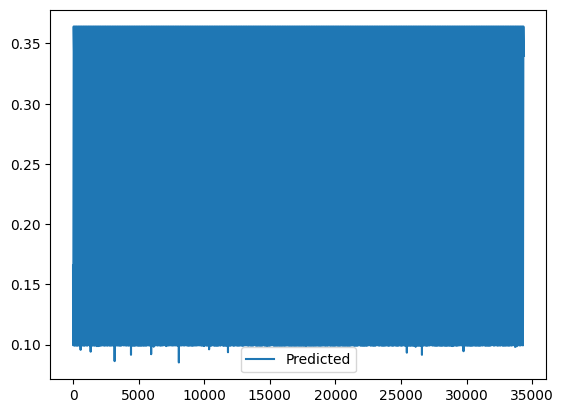

In [167]:
plt.plot(outs, label='Predicted')
plt.legend()
plt.show()